<a target="_blank" href="https://colab.research.google.com/github/rohitm487/GenAI-Tutorial/blob/main/LLM_Inference_optimization_KV_Caching.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install transformers
!pip3 install torch torchaudio torchvision torchtext torchdata

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

- Iteratively generate token one at a time.
  - Prefill and Decode phase. Optimizing it with KV caching to speed up attention calculation.

In [1]:
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


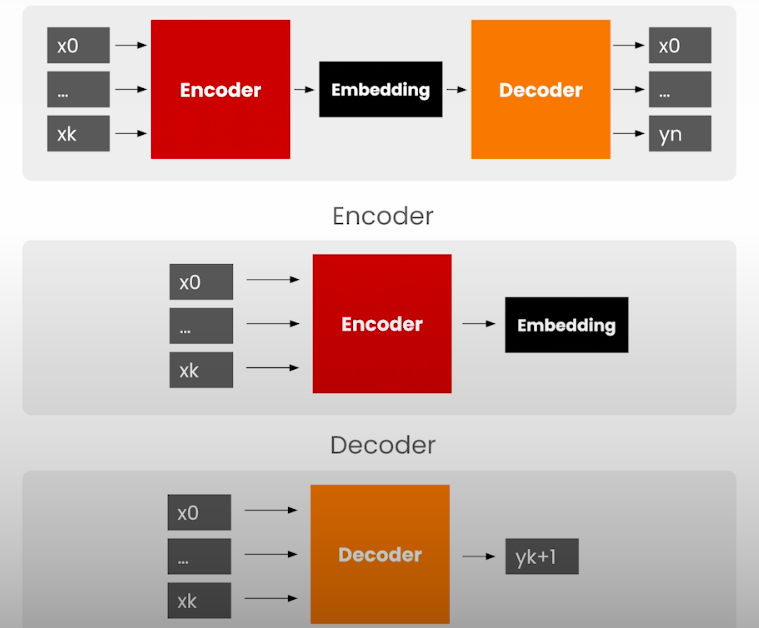

# Decoder Only (Auto regressive model)
- Generates one token at a time.
- Foundation for modern LLM

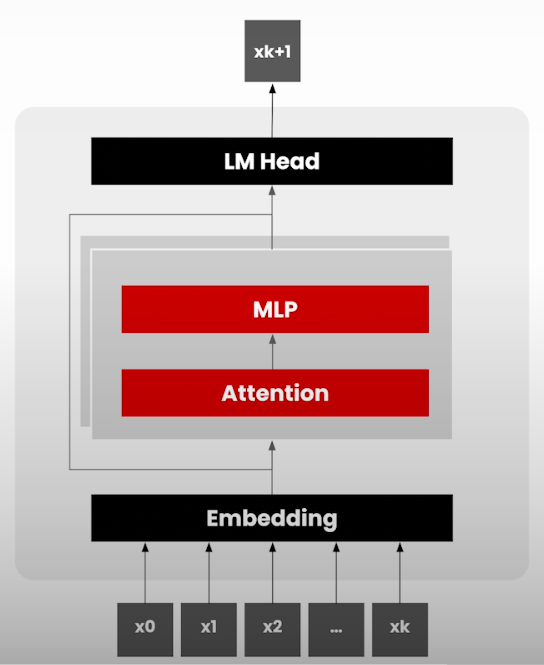

In [32]:
prompt = "There is a"
inputs = tokenizer(prompt,return_tensors = "pt")
inputs

{'input_ids': tensor([[1858,  318,  257]]), 'attention_mask': tensor([[1, 1, 1]])}

EXP - We get token for each word in our prompt. Attention mask we will see later.

In [33]:
# We don't need gradient durning inference, with no grad we specify we don't need memory for extra memory for gredients.
with torch.no_grad():
  outputs = model(input_ids = inputs['input_ids'],attention_mask = inputs["attention_mask"])

logits = outputs.logits
print(logits.shape) # torch.Size([1, 8, 50257]) Batch Size, Sequence Length, vocabulary Size.

torch.Size([1, 3, 50257])


logits shape tells us (Batch Size, Sequence Length, vocabulary Size.). Vocabulary size is 50257 tokens, We want to predict out of these 50257 token which one we want use as the next token.

In [34]:
batch_index = 0 # we have only one batch ["1", 8, 50257]
last_element_idx = -1
#model generates logits for all tokens, for inference we only need last one
last_logits = logits[batch_index,last_element_idx,:] # : specify from all tokens
last_logits,last_logits.shape

(tensor([-107.6652, -105.0714, -109.5767,  ..., -112.3652, -111.6757,
         -106.6163]),
 torch.Size([50257]))

In [35]:
prob = F.log_softmax(last_logits, dim=0)
prob

tensor([-14.4013, -11.8075, -16.3128,  ..., -19.1013, -18.4118, -13.3524])

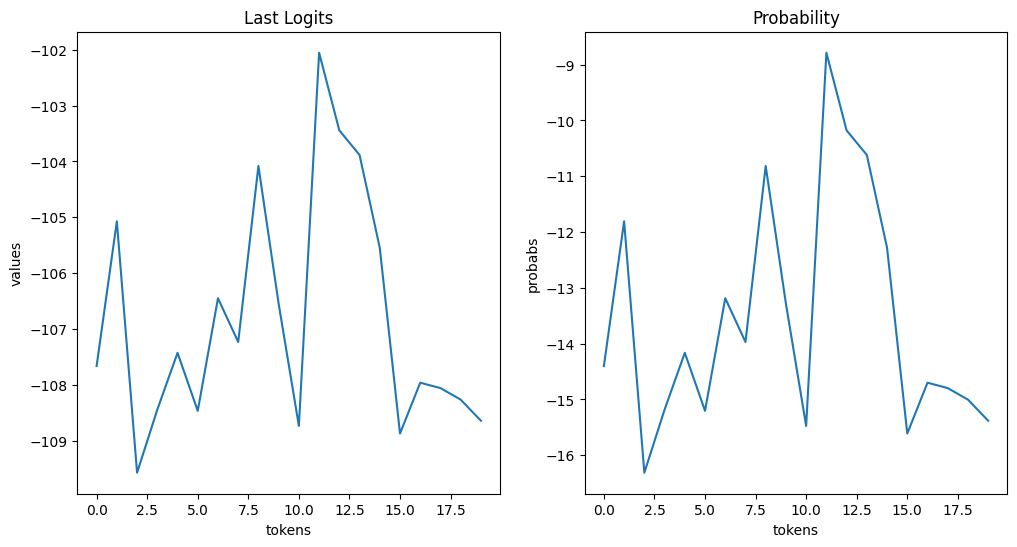

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs[0].plot(last_logits[:20])
axs[0].set_title('Last Logits')
axs[0].set_xlabel("tokens")
axs[0].set_ylabel("values")

# Plot data on the second subplot
axs[1].plot(prob[:20])
axs[1].set_title('Probability')
axs[1].set_xlabel("tokens")
axs[1].set_ylabel("probabs")

plt.show()

In [37]:
next_token_index = last_logits.argmax()
next_token_index

tensor(1256)

In [38]:
tokenizer.decode(next_token_index)

' lot'

# Other recommended tokens

In [39]:
top10_token = torch.topk(last_logits,k=10)
top10_token

torch.return_types.topk(
values=tensor([-95.7501, -97.0276, -97.0907, -97.3788, -97.5056, -97.5881, -97.6399,
        -97.6681, -97.7347, -97.7818]),
indices=tensor([1256,  845, 1049, 3236, 1738, 3580,  922, 1913, 1263,  649]))

In [40]:
top10_token_indices = top10_token.indices

In [41]:
tokenizer.decode(top10_token_indices).split(" ")

['',
 'lot',
 'very',
 'great',
 'huge',
 'reason',
 'difference',
 'good',
 'strong',
 'big',
 'new']

Our input -
- `prompt = "Hey there ! How are"`
- `encoded_promt_using_tokenizer is tensor([[10814,   612,  5145,  1374,   389]])`

Our output -
- `output_index = 345`
- `decoded_output =" you"`

Next what -

`next_input = [prev_input + prev_output] predict next token.`

- We will pass this to model input `{'input_ids': [prev_input + prev_output], 'attention_mask': [1, 1, 1, 1, 1] + [1] }`.

In [42]:
next_inputs = {
    'input_ids':
    torch.cat(
    [inputs["input_ids"], next_token_index.reshape((1,1))],
    dim=1
    ),

    'attention_mask':
      torch.cat(
          [inputs["attention_mask"], torch.tensor([[1]])],
          dim=1
          )
      }

In [43]:
next_inputs

{'input_ids': tensor([[1858,  318,  257, 1256]]),
 'attention_mask': tensor([[1, 1, 1, 1]])}

previous `{'input_ids': tensor([[10814,   612,  5145,  1374,   389]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}`

# Calculate time in generating next token

In [44]:
def next_token_fun(inputs):
  with torch.no_grad():
    outputs = model(**inputs)
  logits = outputs.logits
  last_logits = logits[0,-1,:]
  next_token = last_logits.argmax()
  return next_token

next_token_fun(inputs)

tensor(1256)

Text(0, 0.5, 'time')

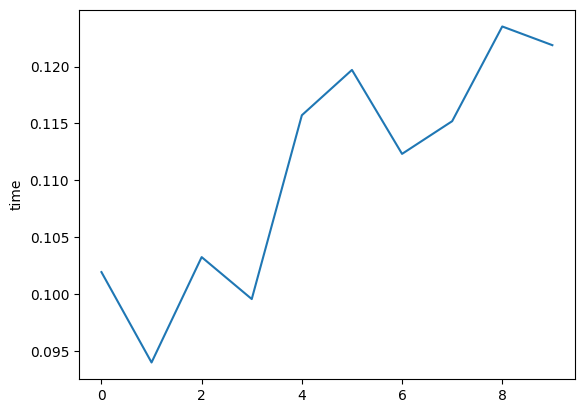

In [45]:
gen_tokens = []
next_inputs = inputs
#print(next_inputs)
durations = []
for _ in range(10):
  start = time.time()
  #print(next_inputs)
  next_token_idx = next_token_fun(next_inputs)
  end = time.time()
  durations.append(end - start)

  next_inputs = {
    'input_ids':
    torch.cat(
    [next_inputs["input_ids"], next_token_idx.reshape((1,1))],
    dim=1
    ),

    'attention_mask':
      torch.cat(
          [next_inputs["attention_mask"], torch.tensor([[1]])],
          dim=1
          )
      }

  next_token = tokenizer.decode(next_token_idx)
  gen_tokens.append(next_token)



plt.plot(durations)
plt.ylabel("time")

In [46]:
gen_tokens

[' lot',
 ' of',
 ' work',
 ' to',
 ' be',
 ' done',
 ' to',
 ' make',
 ' sure',
 ' that']

This is where the cost of lot of llm comes from.

In transformer most of computation cost is associated with attention calculation.
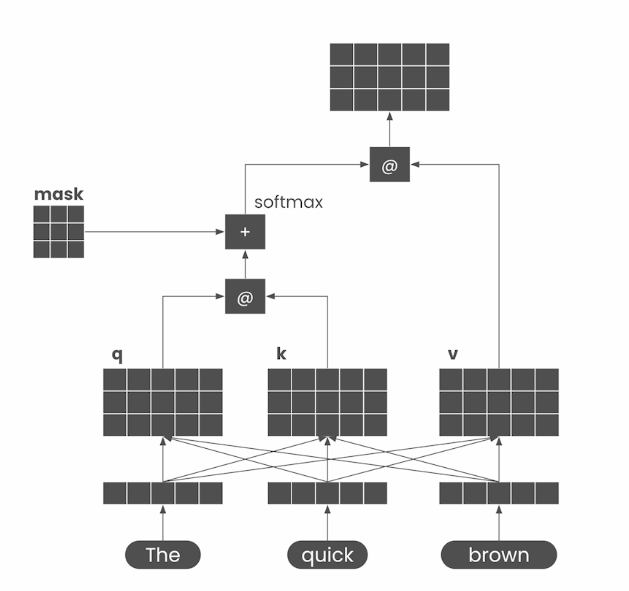

# In LLMS choice of selecting of these some of less likely tokens depends on temperature.

# KV Caching

- During Traing Q,K and V vectors are learned from data.

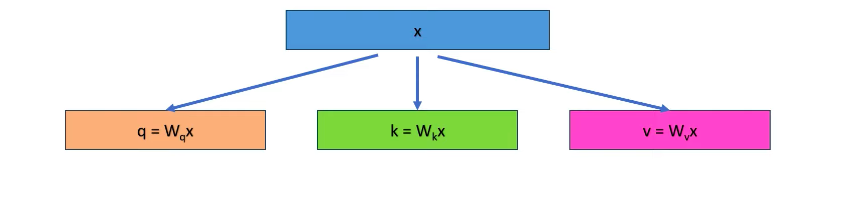







- During Inference
  - Attention scores between the query and each key.

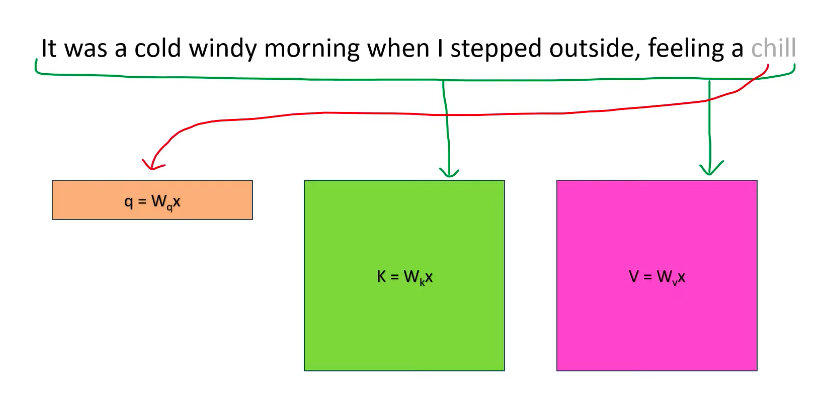





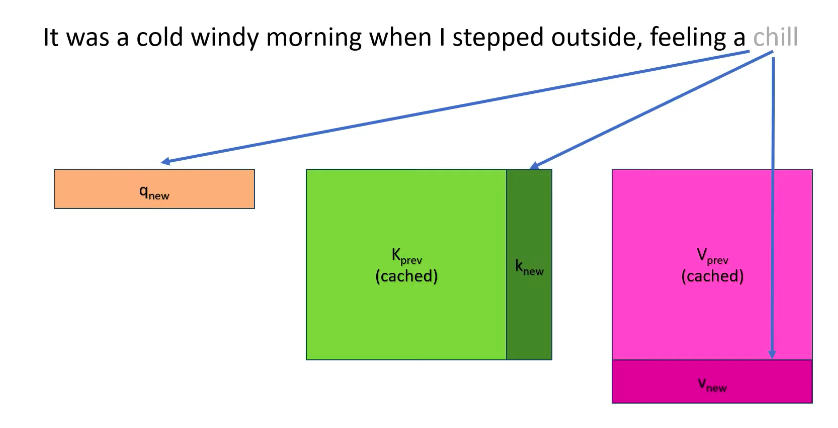









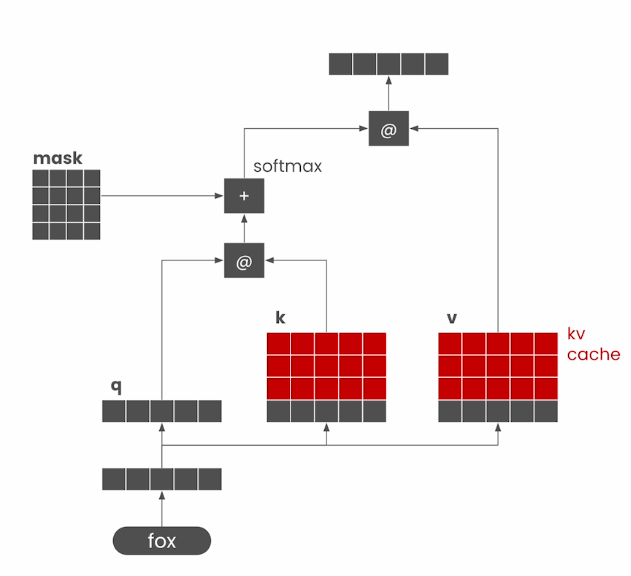

In [124]:
def next_token_past_kv(inputs):
  with torch.no_grad():
    outputs = model(**inputs)
  logits = outputs.logits
  last_logits = logits[0,-1,:]
  next_token = last_logits.argmax()
  return next_token,outputs.past_key_values


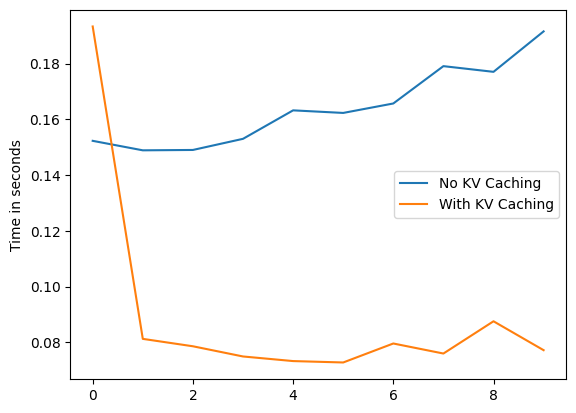

In [125]:
gen_tokens = []
next_inputs = inputs
durations_cache = []
for _ in range(10):
  start = time.time()

  next_token_idx , past_key_values = next_token_past_kv(next_inputs)

  end = time.time()
  durations_cache.append(end - start)

  next_inputs = {
    'input_ids': next_token_idx.reshape((1,1)),

    'attention_mask':
      torch.cat(
          [next_inputs["attention_mask"], torch.tensor([[1]])],
          dim=1
          ),

      'past_key_values':past_key_values

      }

  next_token = tokenizer.decode(next_token_idx)
  gen_tokens.append(next_token)


plt.plot(durations,label="No KV Caching")
plt.plot(durations_cache,label="With KV Caching")
plt.ylabel("Time in seconds")
plt.legend()
plt.show()

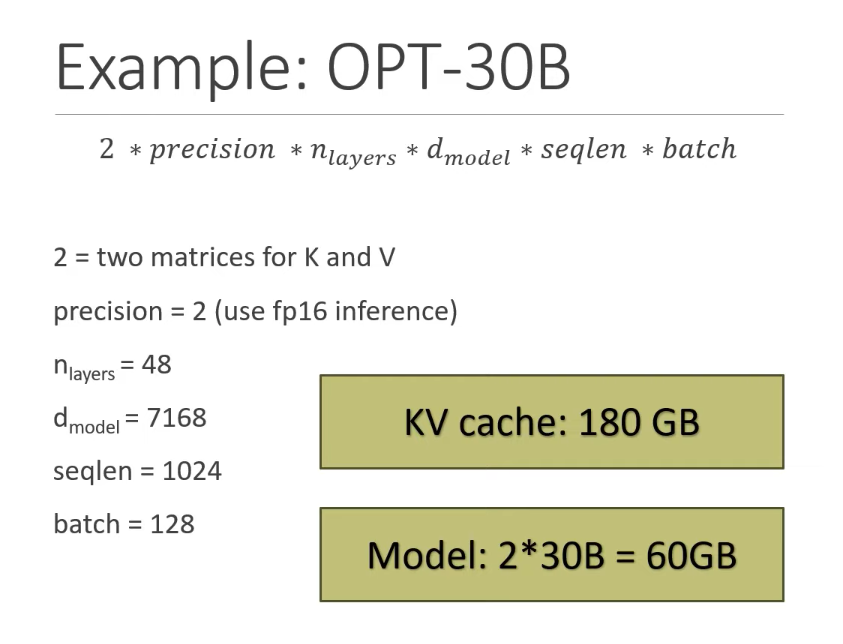

# Paged Attention